# Image Segmentation of Handwritten Digits

<img src='https://drive.google.com/uc?export=view&id=1-WBX7w_R9abwdGmAUBFWWEcJ0LkMppq2' alt='m2nist digits'>

In this notebook, we'll develop a model that predicts segmentation masks for handwritten digits using the [M2NIST dataset](https://www.kaggle.com/farhanhubble/multimnistm2nist), a variation of the classic MNIST dataset that includes multiple digits. This task involves building a Convolutional Neural Network (CNN) for the downsampling path and utilizing a Fully Convolutional Network, FCN-8, for upsampling to generate pixel-wise label maps.

**Model Overview:**
- **Downsampling**: The CNN will capture essential features at various resolutions. This downsampling process compresses the image into a rich feature representation, which is critical for the upsampling phase.
  
- **Upsampling**: The FCN-8 architecture will then be used to upsample these features back to the original image size, providing detailed segmentation masks that predict the class of each pixel.

**Evaluation Metrics:**
- The model’s performance will be assessed using the Intersection Over Union (IOU) and the Dice Score, two common metrics for evaluating the accuracy of segmentation models. These metrics will help quantify how closely the predicted masks match the actual annotations in the dataset.

## Steps

These are the 5 steps we will perform we can successfully get the segmentation masks.

* [Step 1 ─ Define the Basic Convolution Block](#step-1)
* [Step 2 ─ Define the Downsampling Path](#step-2)
* [Step 3 ─ Define the FCN-8 decoder](#step-3)
* [Step 4 ─ Compile the Model](#step-4)
* [Step 5 ─ Model Training](#step-5)

## Imports

In [ ]:
import os
import zipfile
import PIL.Image, PIL.ImageFont, PIL.ImageDraw
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

print("Tensorflow version " + tf.__version__)

Tensorflow version 2.15.0


## Download the dataset

The [M2NIST dataset](https://www.kaggle.com/farhanhubble/multimnistm2nist) is an extension of the traditional [MNIST dataset](http://yann.lecun.com/exdb/mnist/), featuring images with up to three digits. Each image comes with a corresponding label file that includes the segmentation masks.

Although this dataset is available on [Kaggle](https://www.kaggle.com), for convenience, it's also hosted on Google Cloud. This allows for direct downloading without needing Kaggle credentials, facilitating easier access and use in projects.

In [ ]:
# Download and extract the Multidigit MNIST dataset from https://www.kaggle.com/datasets/farhanhubble/multimnistm2nist and unzip to folder m2nist

!kaggle datasets download -d farhanhubble/multimnistm2nist -p /tmp
!unzip /tmp/multimnistm2nist.zip -d /tmp/m2nist

Dataset URL: https://www.kaggle.com/datasets/farhanhubble/multimnistm2nist
License(s): CC-BY-SA-4.0
100% 16.6M/16.6M [00:01<00:00, 17.3MB/s]
100% 16.6M/16.6M [00:01<00:00, 9.07MB/s]
Archive:  /tmp/multimnistm2nist.zip
  inflating: /tmp/m2nist/combined.npy  
  inflating: /tmp/m2nist/segmented.npy  


## Load and Preprocess the Dataset

The dataset is conveniently provided as Numpy Array Files (.npy), which simplifies the preprocessing steps:

1. **combined.npy** contains the image files, each showcasing multiple MNIST digits. The dimensions for each image are **64 x 84** pixels (height x width).

2. **segmented.npy** includes the corresponding segmentation masks for the images, matching the same size of **64 x 84**.

With a total of **5000** samples in the dataset, we can structure suitable training, validation, and test splits according to the project's requirements.

Next, we'll develop a few utility functions to facilitate loading and preprocessing the data effectively. This setup will ensure that the dataset is ready for model training and evaluation.

In [ ]:
BATCH_SIZE = 32

def read_image_and_annotation(image, annotation):
  '''
  Casts the image and annotation to their expected data type and
  normalizes the input image so that each pixel is in the range [-1, 1]

  Args:
    image (numpy array) -- input image
    annotation (numpy array) -- ground truth label map

  Returns:
    preprocessed image-annotation pair
  '''

  image = tf.cast(image, dtype=tf.float32)
  image = tf.reshape(image, (image.shape[0], image.shape[1], 1,))
  annotation = tf.cast(annotation, dtype=tf.int32)
  image = image / 127.5
  image -= 1

  return image, annotation


def get_training_dataset(images, annos):
  '''
  Prepares shuffled batches of the training set.

  Args:
    images (list of strings) -- paths to each image file in the train set
    annos (list of strings) -- paths to each label map in the train set

  Returns:
    tf Dataset containing the preprocessed train set
  '''
  training_dataset = tf.data.Dataset.from_tensor_slices((images, annos))
  training_dataset = training_dataset.map(read_image_and_annotation)

  training_dataset = training_dataset.shuffle(512, reshuffle_each_iteration=True)
  training_dataset = training_dataset.batch(BATCH_SIZE)
  training_dataset = training_dataset.repeat()
  training_dataset = training_dataset.prefetch(-1)

  return training_dataset


def get_validation_dataset(images, annos):
  '''
  Prepares batches of the validation set.

  Args:
    images (list of strings) -- paths to each image file in the val set
    annos (list of strings) -- paths to each label map in the val set

  Returns:
    tf Dataset containing the preprocessed validation set
  '''
  validation_dataset = tf.data.Dataset.from_tensor_slices((images, annos))
  validation_dataset = validation_dataset.map(read_image_and_annotation)
  validation_dataset = validation_dataset.batch(BATCH_SIZE)
  validation_dataset = validation_dataset.repeat()

  return validation_dataset


def get_test_dataset(images, annos):
  '''
  Prepares batches of the test set.

  Args:
    images (list of strings) -- paths to each image file in the test set
    annos (list of strings) -- paths to each label map in the test set

  Returns:
    tf Dataset containing the preprocessed validation set
  '''
  test_dataset = tf.data.Dataset.from_tensor_slices((images, annos))
  test_dataset = test_dataset.map(read_image_and_annotation)
  test_dataset = test_dataset.batch(BATCH_SIZE, drop_remainder=True)

  return test_dataset


def load_images_and_segments():
  '''
  Loads the images and segments as numpy arrays from npy files
  and makes splits for training, validation and test datasets.

  Returns:
    3 tuples containing the train, val, and test splits
  '''

  #Loads images and segmentation masks.
  images = np.load('/tmp/m2nist/combined.npy')
  segments = np.load('/tmp/m2nist/segmented.npy')

  #Makes training, validation, test splits from loaded images and segmentation masks.
  train_images, val_images, train_annos, val_annos = train_test_split(images, segments, test_size=0.2, shuffle=True)
  val_images, test_images, val_annos, test_annos = train_test_split(val_images, val_annos, test_size=0.2, shuffle=True)

  return (train_images, train_annos), (val_images, val_annos), (test_images, test_annos)


We can now proceed to load the preprocessed dataset and establish the training, validation, and test sets. This step will ensure that our data is appropriately partitioned for effective model training, validation, and performance evaluation.

In [ ]:
# Load Dataset
train_slices, val_slices, test_slices = load_images_and_segments()

# Create training, validation, test datasets.
training_dataset = get_training_dataset(train_slices[0], train_slices[1])
validation_dataset = get_validation_dataset(val_slices[0], val_slices[1])
test_dataset = get_test_dataset(test_slices[0], test_slices[1])

## Let's Take a Look at the Dataset

It's beneficial to visually inspect the dataset both before and after training. To facilitate this, we've included utility functions that will allow us to display a selection of images along with their corresponding annotations (i.e., labels). This visual inspection helps ensure that our preprocessing steps are correct and assess the model's performance in segmenting the images accurately.

In [ ]:
# Visualization Utilities

# There are 11 classes in the dataset: one class for each digit (0 to 9) plus the background class
n_classes = 11

# Assign a random color for each class
colors = [tuple(np.random.randint(256, size=3) / 255.0) for i in range(n_classes)]

def fuse_with_pil(images):
  '''
  Creates a blank image and pastes input images

  Args:
    images (list of numpy arrays) - numpy array representations of the images to paste

  Returns:
    PIL Image object containing the images
  '''

  widths = (image.shape[1] for image in images)
  heights = (image.shape[0] for image in images)
  total_width = sum(widths)
  max_height = max(heights)

  new_im = PIL.Image.new('RGB', (total_width, max_height))

  x_offset = 0
  for im in images:
    pil_image = PIL.Image.fromarray(np.uint8(im))
    new_im.paste(pil_image, (x_offset,0))
    x_offset += im.shape[1]

  return new_im


def give_color_to_annotation(annotation):
  '''
  Converts a 2-D annotation to a numpy array with shape (height, width, 3) where
  the third axis represents the color channel. The label values are multiplied by
  255 and placed in this axis to give color to the annotation

  Args:
    annotation (numpy array) - label map array

  Returns:
    the annotation array with an additional color channel/axis
  '''
  seg_img = np.zeros( (annotation.shape[0],annotation.shape[1], 3) ).astype('float')

  for c in range(n_classes):
    segc = (annotation == c)
    seg_img[:,:,0] += segc*( colors[c][0] * 255.0)
    seg_img[:,:,1] += segc*( colors[c][1] * 255.0)
    seg_img[:,:,2] += segc*( colors[c][2] * 255.0)

  return seg_img


def show_annotation_and_prediction(image, annotation, prediction, iou_list, dice_score_list):
  '''
  Displays the images with the ground truth and predicted label maps. Also overlays the metrics.

  Args:
    image (numpy array) -- the input image
    annotation (numpy array) -- the ground truth label map
    prediction (numpy array) -- the predicted label map
    iou_list (list of floats) -- the IOU values for each class
    dice_score_list (list of floats) -- the Dice Score for each class
  '''

  new_ann = np.argmax(annotation, axis=2)
  true_img = give_color_to_annotation(new_ann)
  pred_img = give_color_to_annotation(prediction)

  image = image + 1
  image = image * 127.5
  image = np.reshape(image, (image.shape[0], image.shape[1],))
  image = np.uint8(image)
  images = [image, np.uint8(pred_img), np.uint8(true_img)]

  metrics_by_id = [(idx, iou, dice_score) for idx, (iou, dice_score) in enumerate(zip(iou_list, dice_score_list)) if iou > 0.0 and idx < 10]
  metrics_by_id.sort(key=lambda tup: tup[1], reverse=True)  # sorts in place

  display_string_list = ["{}: IOU: {} Dice Score: {}".format(idx, iou, dice_score) for idx, iou, dice_score in metrics_by_id]
  display_string = "\n".join(display_string_list)

  plt.figure(figsize=(15, 4))

  for idx, im in enumerate(images):
    plt.subplot(1, 3, idx+1)
    if idx == 1:
      plt.xlabel(display_string)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(im)


def show_annotation_and_image(image, annotation):
  '''
  Displays the image and its annotation side by side

  Args:
    image (numpy array) -- the input image
    annotation (numpy array) -- the label map
  '''
  new_ann = np.argmax(annotation, axis=2)
  seg_img = give_color_to_annotation(new_ann)

  image = image + 1
  image = image * 127.5
  image = np.reshape(image, (image.shape[0], image.shape[1],))

  image = np.uint8(image)
  images = [image, seg_img]

  images = [image, seg_img]
  fused_img = fuse_with_pil(images)
  plt.imshow(fused_img)


def list_show_annotation(dataset, num_images):
  '''
  Displays images and its annotations side by side

  Args:
    dataset (tf Dataset) -- batch of images and annotations
    num_images (int) -- number of images to display
  '''
  ds = dataset.unbatch()

  plt.figure(figsize=(20, 15))
  plt.title("Images And Annotations")
  plt.subplots_adjust(bottom=0.1, top=0.9, hspace=0.05)

  for idx, (image, annotation) in enumerate(ds.take(num_images)):
    plt.subplot(5, 5, idx + 1)
    plt.yticks([])
    plt.xticks([])
    show_annotation_and_image(image.numpy(), annotation.numpy())


We can view a subset of the images from the dataset using the `list_show_annotation()` function we defined earlier. By running the cells below, we'll be able to see each image on the left paired with its pixel-wise ground truth label map on the right, providing a clear visual comparison between the original images and their corresponding segmentation annotations.

<ipython-input-5-27847c4c4784>:136: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(5, 5, idx + 1)


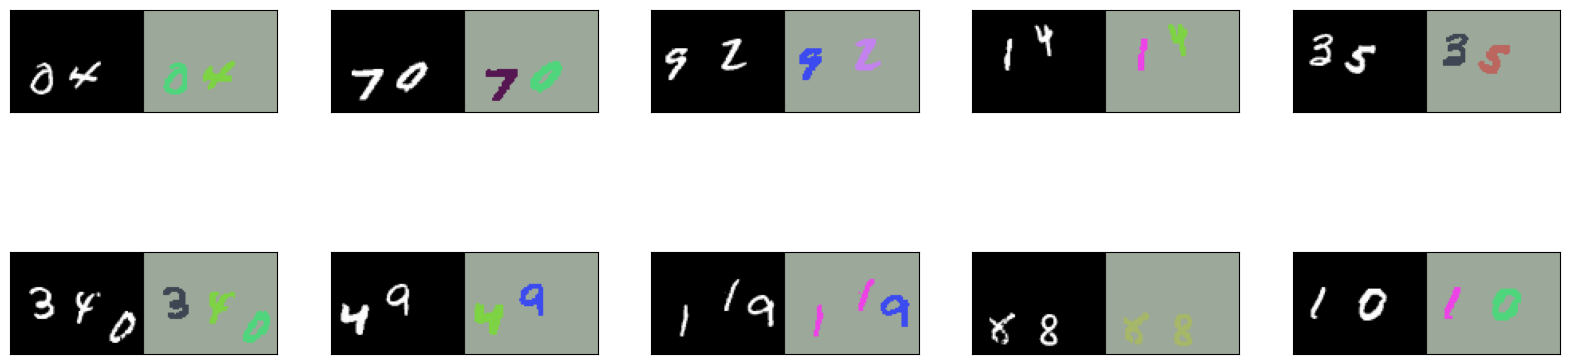

In [ ]:
# Get 10 images from the training set
list_show_annotation(training_dataset, 10)

<ipython-input-5-27847c4c4784>:136: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(5, 5, idx + 1)


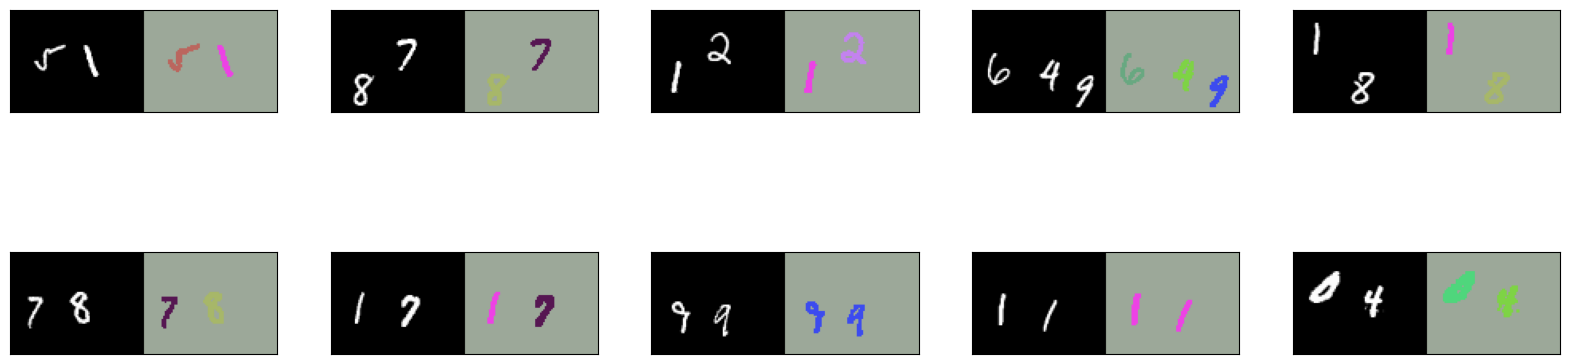

In [ ]:
# Get 10 images from the validation set
list_show_annotation(validation_dataset, 10)

From the images displayed, we can observe the colors assigned to each class, ranging from 0 to 9, plus the background. If the current color scheme isn't to our liking, we can rerun the cell where the `colors` variable is defined to generate a new set of random colors. Alternatively, for more consistent results, we can specify the RGB values manually for each class instead of depending on random assignments. This approach allows for custom visualization that can be tailored to enhance clarity or meet specific aesthetic preferences.

## Define the Model

The image segmentation model we're developing will be structured into two main paths, each serving distinct functions:

1. **Downsampling Path**: This segment of the network is responsible for feature extraction. It employs a series of convolutional and pooling layers that progressively reduce the spatial dimensions of the input image while deepening its feature representation. The outcome is a condensed feature map that captures essential information from the original image. For this path, we'll design a custom Convolutional Neural Network (CNN) from scratch.

2. **Upsampling Path**: Following the downsampling path, this part of the network takes the compressed feature output and begins the process of upsampling it back to the original image dimensions. Throughout this process, it also generates pixel-wise predictions for the segmentation map. This path will utilize an FCN-8 decoder, which is well-suited for detailed upsampling tasks, ensuring that the spatial details lost during downsampling are effectively recovered.

By integrating these two paths, our model will be capable of performing precise image segmentation, converting raw image inputs into detailed and accurate segmentation maps.

### Define the Basic Convolution Block

<a name='step-1'></a>

#### **Step 1**

In the function below we will build the basic convolution block for our CNN. This will have two [Conv2D](https://keras.io/api/layers/convolution_layers/convolution2d/) layers each followed by a [LeakyReLU](https://keras.io/api/layers/activation_layers/leaky_relu/), then [max pooled](https://keras.io/api/layers/pooling_layers/max_pooling2d/) and [batch-normalized](https://keras.io/api/layers/normalization_layers/batch_normalization/). We will use the functional syntax to stack these layers.

<br/>

$$Input -> Conv2D -> LeakyReLU -> Conv2D -> LeakyReLU -> MaxPooling2D -> BatchNormalization$$

<br/>

When defining the Conv2D layers, note that our data inputs will have the 'channels' dimension last. To know more check the `data_format` argument in the [docs](https://keras.io/api/layers/convolution_layers/convolution2d/) regarding this.

To incorporate the `LeakyReLU` activation function into our model, it's efficient and straightforward to apply it directly as a layer, rather than embedding it within an `Activation` layer. This approach simplifies the model architecture and can be implemented as follows: we simply stack the `LeakyReLU` layer directly into the network, using `x = tf.keras.layers.LeakyReLU()(x)`. This direct method is not only cleaner but ensures that the `LeakyReLU` properties are utilized effectively without any unnecessary nesting of functions.

In [ ]:
# Parameter describing where the channel dimension is found in our dataset
IMAGE_ORDERING = 'channels_last'

def conv_block(input, filters, kernel_size, pooling_size, pool_strides, name=None):
  '''
  Args:
    input (tensor) -- batch of images or features
    filters (int) -- number of filters of the Conv2D layers
    kernel_size (int) -- kernel_size setting of the Conv2D layers
    pooling_size (int) -- pooling size of the MaxPooling2D layers
    pool_strides (int) -- strides setting of the MaxPooling2D layers

  Returns:
    (tensor) max pooled and batch-normalized features of the input
  '''
  # Use the functional syntax to stack the layers as shown in the diagram above
  x = tf.keras.layers.Conv2D(filters, kernel_size, padding='same', data_format=IMAGE_ORDERING)(input)
  x = tf.keras.layers.LeakyReLU()(x)
  x = tf.keras.layers.Conv2D(filters, kernel_size, padding='same', data_format=IMAGE_ORDERING)(x)
  x = tf.keras.layers.LeakyReLU()(x)
  x = tf.keras.layers.MaxPool2D()(x)
  x = tf.keras.layers.BatchNormalization()(x)

  return x

In [ ]:
test_input = tf.keras.layers.Input(shape=(64,84, 1), name='input_layer_convblock')
test_output = conv_block(test_input, 32, 3, 2, 2)
test_model = tf.keras.Model(inputs=test_input, outputs=test_output, name='Conv Block')

print(test_model.summary())

# Free up test resources as they are not needed
del test_input, test_output, test_model

Model: "Conv Block"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer_convblock (Inp  [(None, 64, 84, 1)]       0         
 utLayer)                                                        
                                                                 
 conv2d (Conv2D)             (None, 64, 84, 32)        320       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 64, 84, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 84, 32)        9248      
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 64, 84, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 42, 32)        0         
 D)                                                     

### Define the Downsampling Path

<a name='step-2'></a>

#### **Step 2**

To construct the downsampling path of our encoder, we'll integrate multiple convolutional building blocks. This sequence will form the backbone of our feature extraction CNN, focusing on processing and reducing the spatial dimensions of the input image while deepening the feature maps.

**Key Implementation Details:**

1. **Zero Padding**: Initially, to maintain a manageable output dimension throughout the network layers, we apply zero-padding to the input image. This step is handled with the `ZeroPadding2D` layer, specifically padding the width to 96 pixels. This adjustment ensures that the subsequent convolutional layers process a dimensionally stable input, which can be particularly useful for maintaining consistent feature map sizes across the network. While this padding is helpful for a standard setup, it's adjustable based on specific requirements and can be modified or removed to observe its impact on the network's parameterization and output dimensions.

2. **Pooling Consistency**: Throughout the encoder, maintaining a consistent pool size and stride of 2 is advisable. This consistency helps in systematically reducing the dimensionality of the feature maps by half after each pooling step, simplifying the computational complexity and ensuring a predictable reduction in spatial dimensions.

In [ ]:
def FCN8(input_height=64, input_width=84):
    '''
    Defines the downsampling path of the image segmentation model.

    Args:
      input_height (int) -- height of the images
      width (int) -- width of the images

    Returns:
    (tuple of tensors, tensor)
      tuple of tensors -- features extracted at blocks 3 to 5
      tensor -- copy of the input
    '''

    img_input = tf.keras.layers.Input(shape=(input_height,input_width, 1), name='input_layer')

    # Pad the input image width to 96 pixels
    x = tf.keras.layers.ZeroPadding2D(((0, 0), (0, 96-input_width)), name='zero_padding')(img_input)

    # Block 1
    x = conv_block(input=x, filters=32, kernel_size=(3,3), pooling_size=(2,2), pool_strides=(2,2))

    # Block 2
    x = conv_block(input=x, filters=64, kernel_size=(3,3), pooling_size=(2,2), pool_strides=(2,2), name='conv_block_2')

    # Block 3
    x = conv_block(input=x, filters=128, kernel_size=(3,3), pooling_size=(2,2), pool_strides=(2,2), name='conv_block_3')
    # Save the feature map at this stage
    f3 = x

    # Block 4
    x = conv_block(input=x, filters=256, kernel_size=(3,3), pooling_size=(2,2), pool_strides=(2,2), name='conv_block_4')
    # Save the feature map at this stage
    f4 = x

    # Block 5
    x = conv_block(input=x, filters=256, kernel_size= (3,3), pooling_size=(2,2), pool_strides=(2,2), name='conv_block_5')
    # Save the feature map at this stage
    f5 = x

    return (f3, f4, f5), img_input

In [ ]:
# Test

test_convs, test_img_input = FCN8()
test_model = tf.keras.Model(inputs=test_img_input, outputs=[test_convs, test_img_input], name='FCN')

print(test_model.summary())

del test_convs, test_img_input, test_model

Model: "FCN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 64, 84, 1)]       0         
                                                                 
 zero_padding (ZeroPadding2  (None, 64, 96, 1)         0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 96, 32)        320       
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 64, 96, 32)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 64, 96, 32)        9248      
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 64, 96, 32)        0         
                                                               

### Define the FCN-8 decoder

<a name='step-3'></a>

#### **Step 3**

Now we can define the upsampling path taking the outputs of convolutions at each stage as arguments.

Here is also the diagram on how it should work:

<img src='https://drive.google.com/uc?export=view&id=1lrqB4YegV8jXWNfyYAaeuFlwXIc54aRP' alt='fcn-8'>

In [ ]:
def fcn8_decoder(convs, n_classes):
  # Features from the encoder stage
  f3, f4, f5 = convs

  # Number of filters
  n = 512

  # Add convolutional layers on top of the CNN extractor.
  o = tf.keras.layers.Conv2D(n , (7 , 7) , activation='relu' , padding='same', data_format=IMAGE_ORDERING, name='decoder_conv2d_1')(f5)
  o = tf.keras.layers.Dropout(0.5, name='decoder_dropout_1')(o)

  o = tf.keras.layers.Conv2D(n , (1 , 1) , activation='relu' , padding='same', data_format=IMAGE_ORDERING, name='decoder_conv2d_2')(o)
  o = tf.keras.layers.Dropout(0.5, name='decoder_dropout_2')(o)

  o = tf.keras.layers.Conv2D(n_classes,  (1, 1), activation='relu' , padding='same', data_format=IMAGE_ORDERING, name='decoder_conv2d_3')(o)


  # Upsample `o` above and crop any extra pixels introduced
  o = tf.keras.layers.Conv2DTranspose(n_classes, kernel_size=(4,4) , strides=(2,2), use_bias=False, name='decoder_conv2dtranspose_1')(f5)
  o = tf.keras.layers.Cropping2D(cropping=(1,1), name='decoder_cropping2d_1')(o)

  # Load the pool 4 prediction and do a 1x1 convolution to reshape it to the same shape of `o` above
  o2 = f4
  o2 = tf.keras.layers.Conv2D(filters=n_classes , kernel_size=(1,1) , activation='relu' , padding='same', name='decoder_conv2d_4')(o2)

  # Add the results of the upsampling and pool 4 prediction
  o = tf.keras.layers.Add(name='decoder_add_1')([o,o2])

  # Upsample the resulting tensor
  o = tf.keras.layers.Conv2DTranspose(n_classes, kernel_size=(4,4), strides=(2,2), use_bias=False, name='decoder_conv2dtranspose_2')(o)
  o = tf.keras.layers.Cropping2D(cropping=(1,1), name='decoder_cropping2d_2')(o)

  # Load the pool 3 prediction and do a 1x1 convolution to reshape it to the same shape of `o` above
  o2 = f3
  o2 = tf.keras.layers.Conv2D(n_classes , ( 1 , 1 ) , activation='relu' , padding='same', data_format=IMAGE_ORDERING, name='decoder_conv2d_5')(o2)

  # Add the results of the upsampling and pool 3 prediction
  o = tf.keras.layers.Add(name='decoder_add_2')([o,o2])

  # Upsample up to the size of the original image
  o = tf.keras.layers.Conv2DTranspose(filters=n_classes, kernel_size=(8,8) , strides=(8,8), use_bias=False, name='decoder_conv2dtranspose_3')(o)
  o = tf.keras.layers.Cropping2D(((0, 0), (0, 96-84)), name='decoder_cropping2d_3')(o)

  # Append a sigmoid activation
  o = (tf.keras.layers.Activation('sigmoid'))(o)

  return o

In [ ]:
# Test

test_convs, test_img_input = FCN8()
test_fcn8_decoder = fcn8_decoder(test_convs, 11)

print(test_fcn8_decoder.shape)

del test_convs, test_img_input, test_fcn8_decoder

(None, 64, 84, 11)


**Expected Output:**

```txt
(None, 64, 84, 11)
```

### Define the Complete Model

Now that we have defined both the downsampling and upsampling paths, we can combine them to create the full segmentation model. The downsampling path will extract features from the input image, and the upsampling path will restore the image to its original size, producing the segmentation map.

In [ ]:
# Start the encoder using the default input size 64 x 84
convs, img_input = FCN8()

# Pass the convolutions obtained in the encoder to the decoder
dec_op = fcn8_decoder(convs, n_classes)

# Define the model specifying the input (batch of images) and output (decoder output)
model = tf.keras.Model(inputs = img_input, outputs = dec_op, name='Segmentation_Model')

In [ ]:
model.summary()

Model: "Segmentation_Model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_layer (InputLayer)    [(None, 64, 84, 1)]          0         []                            
                                                                                                  
 zero_padding (ZeroPadding2  (None, 64, 96, 1)            0         ['input_layer[0][0]']         
 D)                                                                                               
                                                                                                  
 conv2d_22 (Conv2D)          (None, 64, 96, 32)           320       ['zero_padding[0][0]']        
                                                                                                  
 leaky_re_lu_22 (LeakyReLU)  (None, 64, 96, 32)           0         ['conv2d_22[0

## Compile the Model

<a name='step-4'></a>

### **Step 4**

Now we can compile the model using `binary_crossentropy` as loss, `Adam` optimizer, and `accuracy` as our metric.

In [ ]:
model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])

## Model Training

<a name='step-5'></a>

### **Step 5**

Now that we have built our segmentation model, we can proceed to train it. We'll set the number of epochs and observe the metrics returned at each iteration. If the model performance doesn't improve by monitoring the `val_loss` for 3 consective epochs, we will stop the training. To achieve this we will define a custom `callback`

In [ ]:
# Define the early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

EPOCHS = 20

steps_per_epoch = 4000 // BATCH_SIZE
validation_steps = 800 // BATCH_SIZE
test_steps = 200 // BATCH_SIZE

# Add the early stopping callback to the model.fit() call
history = model.fit(training_dataset,
                    steps_per_epoch=steps_per_epoch,
                    validation_data=validation_dataset,
                    validation_steps=validation_steps,
                    epochs=EPOCHS,
                    callbacks=[early_stopping])

Epoch 1/20
125/125 [==============================] - 17s 36ms/step - loss: 0.1317 - accuracy: 0.8519 - val_loss: 0.0660 - val_accuracy: 0.9424
Epoch 2/20
125/125 [==============================] - 4s 33ms/step - loss: 0.0320 - accuracy: 0.9425 - val_loss: 0.0727 - val_accuracy: 0.9424
Epoch 3/20
125/125 [==============================] - 4s 34ms/step - loss: 0.0286 - accuracy: 0.9427 - val_loss: 0.0420 - val_accuracy: 0.9424
Epoch 4/20
125/125 [==============================] - 4s 31ms/step - loss: 0.0260 - accuracy: 0.9431 - val_loss: 0.0293 - val_accuracy: 0.9426
Epoch 5/20
125/125 [==============================] - 4s 32ms/step - loss: 0.0245 - accuracy: 0.9441 - val_loss: 0.0247 - val_accuracy: 0.9437
Epoch 6/20
125/125 [==============================] - 4s 35ms/step - loss: 0.0234 - accuracy: 0.9458 - val_loss: 0.0232 - val_accuracy: 0.9463
Epoch 7/20
125/125 [==============================] - 4s 32ms/step - loss: 0.0221 - accuracy: 0.9486 - val_loss: 0.0309 - val_accuracy: 0.944

## Model Evaluation

### Make Predictions

Let's obtain the predictions using our test dataset as input and then print the shape of these predictions.

In [ ]:
results = model.predict(test_dataset, steps=test_steps)

print(results.shape)

6/6 [==============================] - 1s 14ms/step
(192, 64, 84, 11)


As observed, the resulting shape is `(192, 64, 84, 11)`. This indicates that for each of the 192 images in our test set, there are 11 predictions generated, corresponding to one for each class (0 to 10) plus the background.

To view the *probability* of the upper leftmost pixel of the first image belonging to class 0, we can print `results[0,0,0,0]`. Similarly, for the probability of the same pixel belonging to class 10, we would print `results[0,0,0,10]`.

In [ ]:
print(results[0,0,0,0])
print(results[0,0,0,10])

0.0010241931
0.9953465


What we are interested in is obtaining the *index* of the highest probability across these 11 slices and combining them into a single image. This can be achieved by using the [argmax](https://numpy.org/doc/stable/reference/generated/numpy.argmax.html) function along this axis.

In [ ]:
results = np.argmax(results, axis=3)

print(results.shape)

(192, 64, 84)


The new array generated per image now only specifies the indices of the class with the highest probability. Let's check the output class of the upper leftmost pixel. As previously observed when inspecting the dataset, the upper left corner typically belongs to the background (class 10). The actual digits are usually located in the middle parts of the image.

In [ ]:
print(results[0,0,0])

# Prediction map for image 0
print(results[0,:,:])

10
[[10 10 10 ... 10 10 10]
 [10 10 10 ... 10 10 10]
 [10 10 10 ... 10 10 10]
 ...
 [10 10 10 ... 10 10 10]
 [10 10 10 ... 10 10 10]
 [10 10 10 ... 10 10 10]]


We will use this `results` array when we evaluate our predictions.

### Metrics

We have used two ways to evaluate the predictions. The *intersection over union (IOU)* and the *dice score*. Recall that:

$$IOU = \frac{area\_of\_overlap}{area\_of\_union}$$
<br>
$$Dice Score = 2 * \frac{area\_of\_overlap}{combined\_area}$$

A small smoothing factor is introduced in the denominators to prevent possible division by zero.

In [ ]:
def class_wise_metrics(y_true, y_pred):
  '''
  Computes the class-wise IOU and Dice Score.

  Args:
    y_true (tensor) - ground truth label maps
    y_pred (tensor) - predicted label maps
  '''
  class_wise_iou = []
  class_wise_dice_score = []

  smoothing_factor = 0.00001

  for i in range(n_classes):
    intersection = np.sum((y_pred == i) * (y_true == i))
    y_true_area = np.sum((y_true == i))
    y_pred_area = np.sum((y_pred == i))
    combined_area = y_true_area + y_pred_area

    iou = (intersection) / (combined_area - intersection + smoothing_factor)
    class_wise_iou.append(iou)

    dice_score =  2 * ((intersection) / (combined_area + smoothing_factor))
    class_wise_dice_score.append(dice_score)

  return class_wise_iou, class_wise_dice_score


### Visualize Predictions

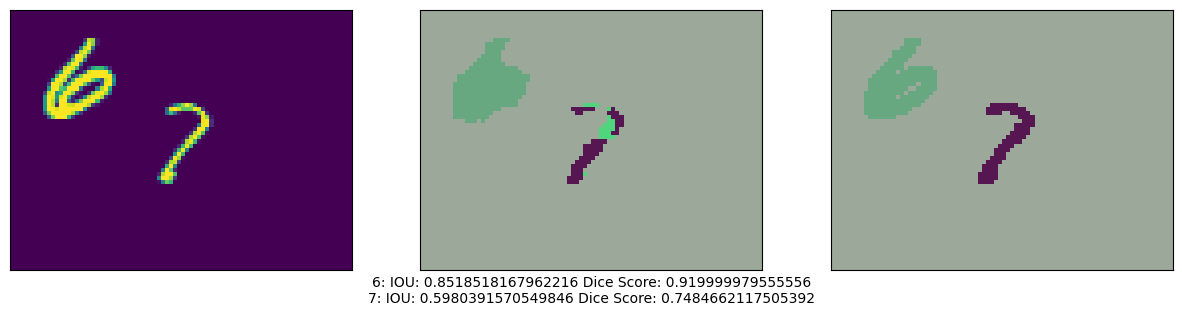

In [ ]:
# Placing a number between 0 to 191 to pick an image from the test set
integer_slider = 147

ds = test_dataset.unbatch()
ds = ds.batch(200)
images = []

y_true_segments = []
for image, annotation in ds.take(2):
  y_true_segments = annotation
  images = image


iou, dice_score = class_wise_metrics(np.argmax(y_true_segments[integer_slider], axis=2), results[integer_slider])
show_annotation_and_prediction(image[integer_slider], annotation[integer_slider], results[integer_slider], iou, dice_score)


### Compute IOU Score and Dice Score of the model

In [ ]:
cls_wise_iou, cls_wise_dice_score = class_wise_metrics(np.argmax(y_true_segments, axis=3), results)

average_iou = 0.0
for idx, (iou, dice_score) in enumerate(zip(cls_wise_iou[:-1], cls_wise_dice_score[:-1])):
  print("Digit {}: IOU: {} Dice Score: {}".format(idx, iou, dice_score))
  average_iou += iou

score = average_iou * 10

print("\nScore is " + str(score))

Digit 0: IOU: 0.7502738215357697 Dice Score: 0.8573216513944606
Digit 1: IOU: 0.7940091148382699 Dice Score: 0.8851784623288828
Digit 2: IOU: 0.7360338667418993 Dice Score: 0.847948742063714
Digit 3: IOU: 0.711059098056104 Dice Score: 0.8311333008473201
Digit 4: IOU: 0.6991576397132188 Dice Score: 0.8229461744717477
Digit 5: IOU: 0.6614065172539663 Dice Score: 0.7962007014961796
Digit 6: IOU: 0.7254061069195502 Dice Score: 0.8408526016111677
Digit 7: IOU: 0.7248243545573295 Dice Score: 0.8404616419546712
Digit 8: IOU: 0.6950503345986433 Dice Score: 0.820094035453193
Digit 9: IOU: 0.6646248076505293 Dice Score: 0.7985280582098118

Score is 71.6184566186528
